Model performances: {'RandomForest': 0.782258064516129, 'LogisticRegression': 0.967741935483871, 'SVM': 0.9274193548387096}


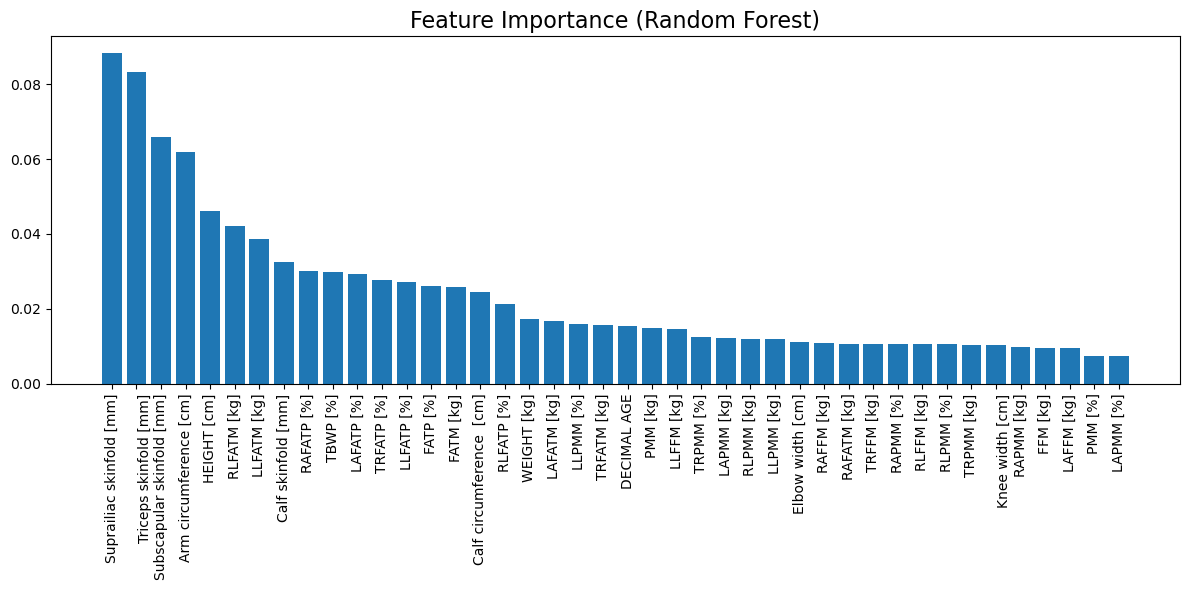

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Clean the datasets by removing unnecessary columns and replacing commas with dots for numeric parsing
def clean_data(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.replace(',', '.', regex=True)
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')
    return df

# Load datasets
df_male = pd.read_csv("male.csv", delimiter=';')
df_female = pd.read_csv("female.csv", delimiter=';')

df_male_clean = clean_data(df_male)
df_female_clean = clean_data(df_female)

# Combine datasets
df_combined = pd.concat([df_male_clean, df_female_clean], ignore_index=True)

# Convert target variables to single "BodyType" column
def classify_body_type(row):
    if row['MESO'] > row['ECTO'] and row['MESO'] > row['ENDO']:
        return 'MESO'
    elif row['ECTO'] > row['MESO'] and row['ECTO'] > row['ENDO']:
        return 'ECTO'
    else:
        return 'ENDO'

df_combined['BodyType'] = df_combined.apply(classify_body_type, axis=1)
df_combined = df_combined.drop(columns=['MESO', 'ECTO', 'ENDO'])

# Prepare features and labels
X = df_combined.drop(columns=['BodyType', 'SEX', 'Code'])
y = df_combined['BodyType']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=5000, solver='saga', random_state=42),
    "SVM": SVC(kernel='linear', random_state=42)
}

best_model = None
best_accuracy = 0
results = {}

for name, model in models.items():
    if name == "LogisticRegression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Save the best model
with open('best_body_type_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model performances:", results)

# Feature importance for Random Forest
if "RandomForest" in models:
    rf_model = models["RandomForest"]
    importances = rf_model.feature_importances_
    feature_names = X.columns

    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importance (Random Forest)", fontsize=16)
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
    plt.tight_layout()
    plt.show()
